# Fundamentos de Robótica Movil

## TP°3: Mediciones de sensor de barrido LASER

### Profesores:
#### Gonzalo Perez Paina
#### David Gaydou
#### Diego Gonzales Dondo

### Alumno:
#### Molins Rodrigo     75569

## Objetivo

#### Analizar mediciones de un sensor de barrido LASER y la relación entre los sistemas de cooordenadas del sensor/robot y del entorno, utilizando para ello el simulador Gazebo.

## Descripción de la actividad

#### Las actividades propuestas a continuación se llevan a cabo utilizando el simulador Gazebo con el modelo de simulación del robot RoMAA-II bajo el entorno ROSDS, puesto en marcha en el trabajo Nro. 1.
#### A partir de las simulaciones se obtendrán archivos de texto con datos de odometría y mediciones del sensor de barrido LASER del robot. Estos datos serán analizados mediante diferentes programas de cálculo numérico a través de gráficos para tal fin.

## Resolución de la actividad

#### Los primeros puntos de esta actividad son con el fin de obtener los datos con los que se trabajará más adelante, por lo que no habrá un análisis detallado de estas actividades.

### 1) Ejecutar el simulador del robot RoMAA utilizando la herramienta roslaunch.
#### > roslaunch romaa_gazebo construction.launch
#### > ROMAA_LASER=1 roslaunch romaa_gazebo spawn_xacro.launch
#### También debe ejecutarse el nodo de teleoperación usado en el TPN°1

### 2) Ejecutar la herramienta de registro de datos:
#### > rosbag record /cmd_vel /odom /scan
#### Esto genera un registro con la extensión .bag en el directorio actual, el cual contiene los datos de odometría y del barrido LASER.

### 3) Mover el robot utilizando el teclado, intentando abarcar la mayor parte del escenario de trabajo del robot. luego detener el registro de datos y los demás programas ejecutados.

### 4) Descargar y construir el paquete de ROS para la conversión de datos. El paquete se debe descargar en el directorio de archivos fuentes con el comando:
#### > git clone https://github.com/ciiiutnfrc/rosbag2txt.git

### 5) Convertir los datos mediante el comando:
#### > roslaunch rosbag2txt rosbag2txt.launch bagfile:=< bagfile >
#### donde < bagfile > es el archivo .bag generado anteriormente.

## Análisis de Datos
### 6) Escribir un script de Python que cargue los datos del archivo scan.txt y genere gráficos en coordenadas polares de 3 barridos del sensor LASER distribuidos de forma uniforme en el tiempo de simulación.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

plt.style.use('classic')

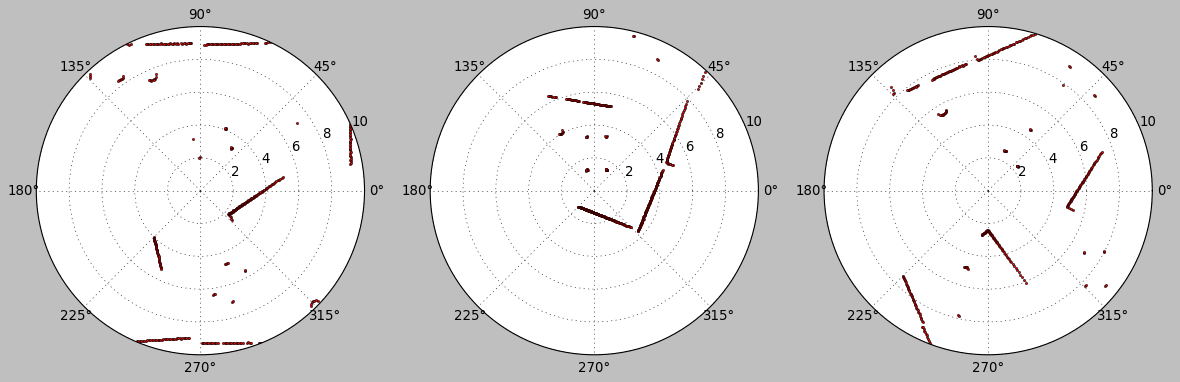

In [3]:
file_key = 'odom.txt'  # Replace for correspoing key
odom = pd.read_csv(file_key, header = None, delim_whitespace=True)
odom.columns =['tiempo', 'posX', 'posY', 'posYaw', 'vel', 'velAngular']
file_key = 'scan.txt'  # Replace for correspoing key
laser = pd.read_csv(file_key, header = None, delim_whitespace=True)
ang=np.linspace(-135, 134.5, 540)
ang=np.radians(ang)
r=np.array([laser.iloc[0,1:]])
fig = plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1, projection='polar')
plt.polar(ang, r[0], 'ro', markersize=2)
r=np.array([laser.iloc[757,1:]])
plt.subplot(1, 3, 2, projection='polar')
plt.polar(ang, r[0], 'ro', markersize=2)
r=np.array([laser.iloc[1514,1:]])
plt.subplot(1, 3, 3, projection='polar')
plt.polar(ang,r[0], 'ro', markersize=2)
plt.show()

#### Estos gráficos muestran el barrido del LASER en tres instantes de tiempo diferentes. Puede notarse que el radio máximo de las lecturas no supera los 10m, esto es por el rango máximo del sensor, como también se ve que no hay lecturas desde el ángulo 135 hasta el 225, debido a que el barrido del LASER no cubre los 90° que se encuentran detrás del robot.

#### Dado que la tasa de muestreo de la odometría no es igual a la del sensor de barrido, cosa que suele ser siempre el caso, se deben usar los datos de odometría más cercanos en el tiempo a los datos obtenidos por el sensor LASER. Para ello:
### 7) Diseñar un algoritmo que determine los índices del vector de timestamp de odometría que se encuentren más próximos a los valores del vector de timestamp de las mediciones del LASER.

In [5]:
offset=odom['tiempo'][0]
laser[0][:]=laser[0][:]-offset
odom['tiempo']=odom['tiempo']-offset
index=np.searchsorted(odom['tiempo'][:],laser[0][:],side='left', sorter=None)
for i in range (1514):
    if(odom['tiempo'][index[i]]-laser[0][i]>abs(odom['tiempo'][index[i]-1]-laser[0][i])):
        index[i]=index[i]-1
print("Los primeros 10 valores del timestamp del sensor de barrido:")
print(laser[0][:10])
print("Los 10 valores del timestamp de odometría que se corresponden con los anteriores:")
print(odom['tiempo'][index[:10]])

Los primeros 10 valores del timestamp del sensor de barrido:
0    0.021
1    0.121
2    0.221
3    0.321
4    0.422
5    0.521
6    0.621
7    0.721
8    0.821
9    0.921
Name: 0, dtype: float64
Los 10 valores del timestamp de odometría que se corresponden con los anteriores:
1     0.04
3     0.12
6     0.24
8     0.32
11    0.44
13    0.52
16    0.64
18    0.72
21    0.84
23    0.92
Name: tiempo, dtype: float64


#### La forma de encontrar los valores del timestamp más próximos es utilizando la función searchsorted de numpy, la cual devuelve los valores del índice que deberían tener los elementos del segundo array para que, introducidos en el primero, mantengan un orden alfabético. Esto nos devuelve de forma aproximada los índices, pues el 2do elemento de "laser.txt" sería el 4to elemento de "odom.txt" para mantener el orden, pero es más próximo el 3er elemento que el 4to, por lo que una vez hecho este primer "acomodo" pasamos a preguntar si ese elemento de odom es el más próximo o si lo es el elemento anterior. De esta forma nos ahorramos el tener que preguntar por cada elemento de odom.

### 8) Mostrar en una gráfica los instantes de tiempo de las mediciones del sensor de barrido LASER y de odometría. Resaltar aquellos instantes de tiempo de mediciones de odometría más próximas a las del sensor de barrido LASER. Mostrar solo un fracción del tiempo total de simulación.

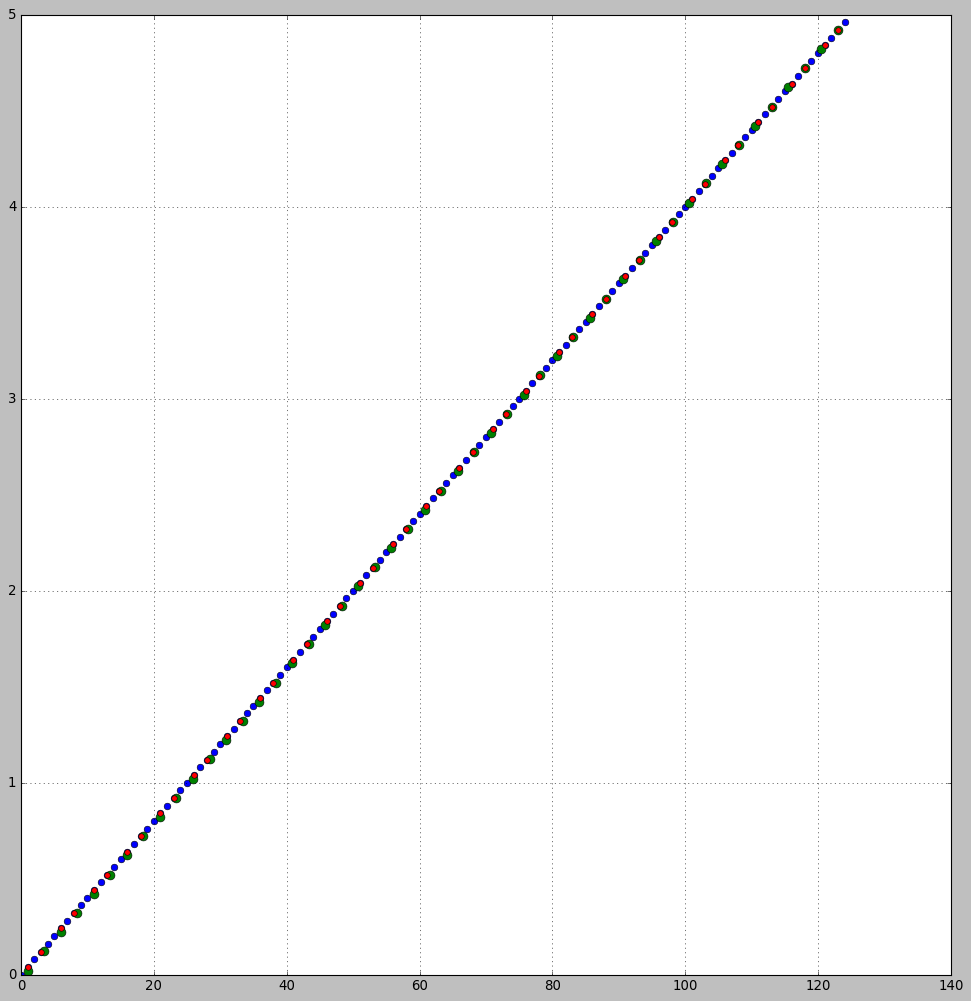

In [64]:
plt.figure(figsize=(15,15))
p=plt.plot(odom['tiempo'][:125],"bo")
p+=plt.plot(np.linspace(index[0],index[49],50),laser[0][0:50],"go",markersize=8)
p+=plt.plot(odom['tiempo'][index[:50]], "ro",markersize=5)
plt.grid()

#### En este gráfico, los puntos azules representan los valores de timestamp de odom, los puntos verdes representan los timestamp de laser y los puntos rojos son los timestamp de odom más próximos a los de laser

### 9) Escribir un script que genere una gráfica del mapa, el cual tiene que:
#### a) Convertir las mediciones del barrido LASER de coordenadas polares a rectangulares.
#### b) Transformar los puntos de medición del sensor LASER al sistema de coordenadas de odometría y gráficar.
#### c) Gráficar junto al mapa el camino seguido por el robot.

(-10, 10)

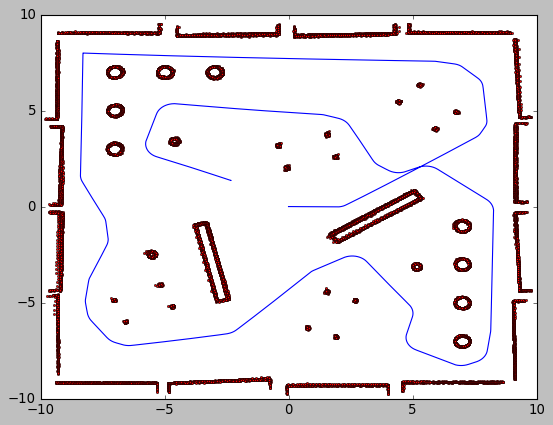

In [12]:
r=np.array([laser.iloc[0,1:]])
x=r*np.cos(ang+odom['posYaw'][index[0]])+odom['posX'][index[0]]
y=r*np.sin(ang+odom['posYaw'][index[0]])+odom['posY'][index[0]]
g=plt.plot(x,y,'ro', markersize=2)
for i in range(1,1514,15):
 r=np.array([laser.iloc[i,1:]])
 x=r*np.cos(ang+odom['posYaw'][index[i]])+odom['posX'][index[i]]
 y=r*np.sin(ang+odom['posYaw'][index[i]])+odom['posY'][index[i]]
 g+=plt.plot(x,y,'ro', markersize=2)
g+=plt.plot(odom['posX'],odom['posY'])
plt.ylim(-10,10)
plt.xlim(-10,10)

#### En este script se realiza el inciso a y b al mismo tiempo, a la vez que las coordenadas pasan de ser polares a rectangulares, se tiene en cuenta la pose del robot para transformar los puntos del sistema de coordenadas del robot a los de la odometría. Para que el proceso sea más rápido, se saltea de a 15 los datos leidos del scaner LASER. Esto no representa un problema porque la velocidad del robot durante la simulación fue baja y no se ve un cambio notable entre una muestra del escaner y la siguiente.

## Conclusiones

#### De esta forma, podemos obtener una nube de puntos que representa el mapa alrededor del recorrido del robot y tener una idea básica del entorno.